#### Mempersiapkan Library

In [32]:
import pandas as pd
import numpy as np
import re
import csv
from string import punctuation
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, classification_report
import pickle

#### Mempersiapkan Dataset

In [33]:
tsv_file_path = "../train_preprocess.tsv.txt"

data_text = []
label = []

with open(tsv_file_path, encoding='utf-8') as tsvfile:
    tsv_reader = csv.reader(tsvfile, delimiter='\t')
    for row in tsv_reader:
        data_text.append(row[0])
        label.append(row[1])

df = pd.DataFrame({'data_text': data_text, 'label': label})

In [34]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

In [35]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(7040, 2)
(2200, 2)
(1760, 2)


In [36]:
print('Komposisi Label train_data:')
print(train_data['label'].value_counts())

print('Komposisi Label test_data:')
print(test_data['label'].value_counts())

print('Komposisi Label val_data:')
print(val_data['label'].value_counts())

Komposisi Label train_data:
positive    4134
negative    2185
neutral      721
Name: label, dtype: int64
Komposisi Label test_data:
positive    1272
negative     688
neutral      240
Name: label, dtype: int64
Komposisi Label val_data:
positive    1010
negative     563
neutral      187
Name: label, dtype: int64


#### Normalisasi Text

In [37]:
def lowercasing(paragraph):
    return paragraph.lower()

In [38]:
def menghilangkan_tandabaca(paragraph):
    new_paragraph = re.sub(fr'[{punctuation}]', r'', paragraph)
    return new_paragraph

In [39]:
def text_normalization(paragraph):
    paragraph = lowercasing(paragraph)
    paragraph = menghilangkan_tandabaca(paragraph)
    paragraph = re.sub(r"[ ]+",r' ',paragraph)
    return paragraph

In [40]:
train_data['data_text'] = train_data['data_text'].apply(lambda x: text_normalization(x))
test_data['data_text'] = test_data['data_text'].apply(lambda x: text_normalization(x))
val_data['data_text'] = val_data['data_text'].apply(lambda x: text_normalization(x))

#### Training Model

In [41]:
tokenizer = Tokenizer(oov_token='<UNK>')

In [42]:
tokenizer.fit_on_texts(train_data['data_text'])

In [43]:
train_data_tf = tokenizer.texts_to_sequences(train_data['data_text'])
test_data_tf = tokenizer.texts_to_sequences(test_data['data_text'])
val_data_tf = tokenizer.texts_to_sequences(val_data['data_text'])

In [44]:
train_data['data_text']

4057     indihome gangguan terus bayar nya saja mahal t...
7811     tempat pemandangan nya luar biasa dan pelayana...
5046     bagaimana kalau netizen pada patungan menyewa ...
7404                                           tidak sehat
8055     ulah sendiri kok gubernur yang disalahkan dasa...
                               ...                        
10959                  saya cemburu tapi tidak bisa apaapa
3997     bubarkan saja dpr rakyat tidak butuh diwakili ...
4118     steak di sini selalu membuat ketagihan menu ke...
5646                                      adit kayak tarik
10675    restoran sumoamg padang dago adalah palung pop...
Name: data_text, Length: 7040, dtype: object

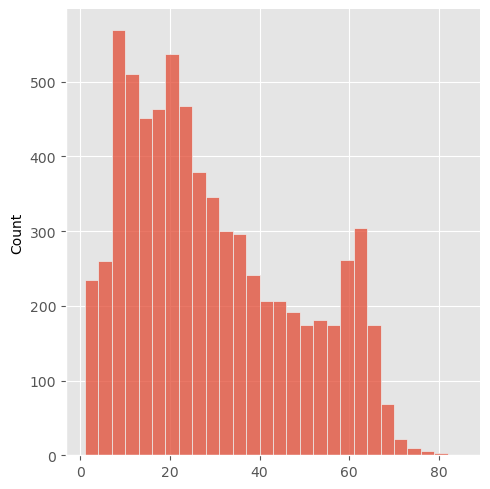

In [45]:
sns.displot([len(x) for x in train_data_tf])

In [46]:
max_len = int(np.quantile([len(x) for x in train_data_tf], 0.9))

In [47]:
max_len

59

In [48]:
train_padded = pad_sequences(sequences = train_data_tf, padding='post', maxlen=max_len)
test_padded = pad_sequences(sequences = test_data_tf, padding='post', maxlen=max_len)
val_padded = pad_sequences(sequences = val_data_tf, padding='post', maxlen=max_len)

In [49]:
print(train_padded.shape)
print(test_padded.shape)
print(val_padded.shape)

(7040, 59)
(2200, 59)
(1760, 59)


In [50]:
onehot = OneHotEncoder()

In [51]:
onehot.fit_transform(train_data[['label']])

<7040x3 sparse matrix of type '<class 'numpy.float64'>'
	with 7040 stored elements in Compressed Sparse Row format>

In [52]:
train_labels = onehot.fit_transform(train_data[['label']]).toarray()

#### Model Testing and Evaluation

In [53]:
model = Sequential()

In [54]:
max_features = len(tokenizer.index_word)
batch_size=16
output_dim = 64
input_len = max_len

In [55]:
model = Sequential()
model.add(layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                           output_dim=output_dim, 
                           input_length=input_len))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [56]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [57]:
maximum_index_training = int(np.floor(train_padded.shape[0]/batch_size)*batch_size)
train = model.fit(x=train_padded[:maximum_index_training], 
          y=train_labels[:maximum_index_training],
          batch_size=batch_size, 
          epochs=20, 
          shuffle=False)

Epoch 1/20
440/440 [==============================] - 12s 25ms/step - loss: 0.5628 - accuracy: 0.7587
Epoch 2/20
440/440 [==============================] - 11s 25ms/step - loss: 0.2267 - accuracy: 0.9170
Epoch 3/20
440/440 [==============================] - 11s 25ms/step - loss: 0.0757 - accuracy: 0.9751
Epoch 4/20
440/440 [==============================] - 19s 44ms/step - loss: 0.0190 - accuracy: 0.9959
Epoch 5/20
440/440 [==============================] - 18s 40ms/step - loss: 0.0052 - accuracy: 0.9994
Epoch 6/20
440/440 [==============================] - 17s 38ms/step - loss: 0.0018 - accuracy: 0.9999
Epoch 7/20
440/440 [==============================] - 16s 37ms/step - loss: 8.2247e-04 - accuracy: 1.0000
Epoch 8/20
440/440 [==============================] - 16s 37ms/step - loss: 3.2608e-04 - accuracy: 1.0000
Epoch 9/20
440/440 [==============================] - 17s 38ms/step - loss: 1.7579e-04 - accuracy: 1.0000
Epoch 10/20
440/440 [==============================] - 15s 35ms/step -

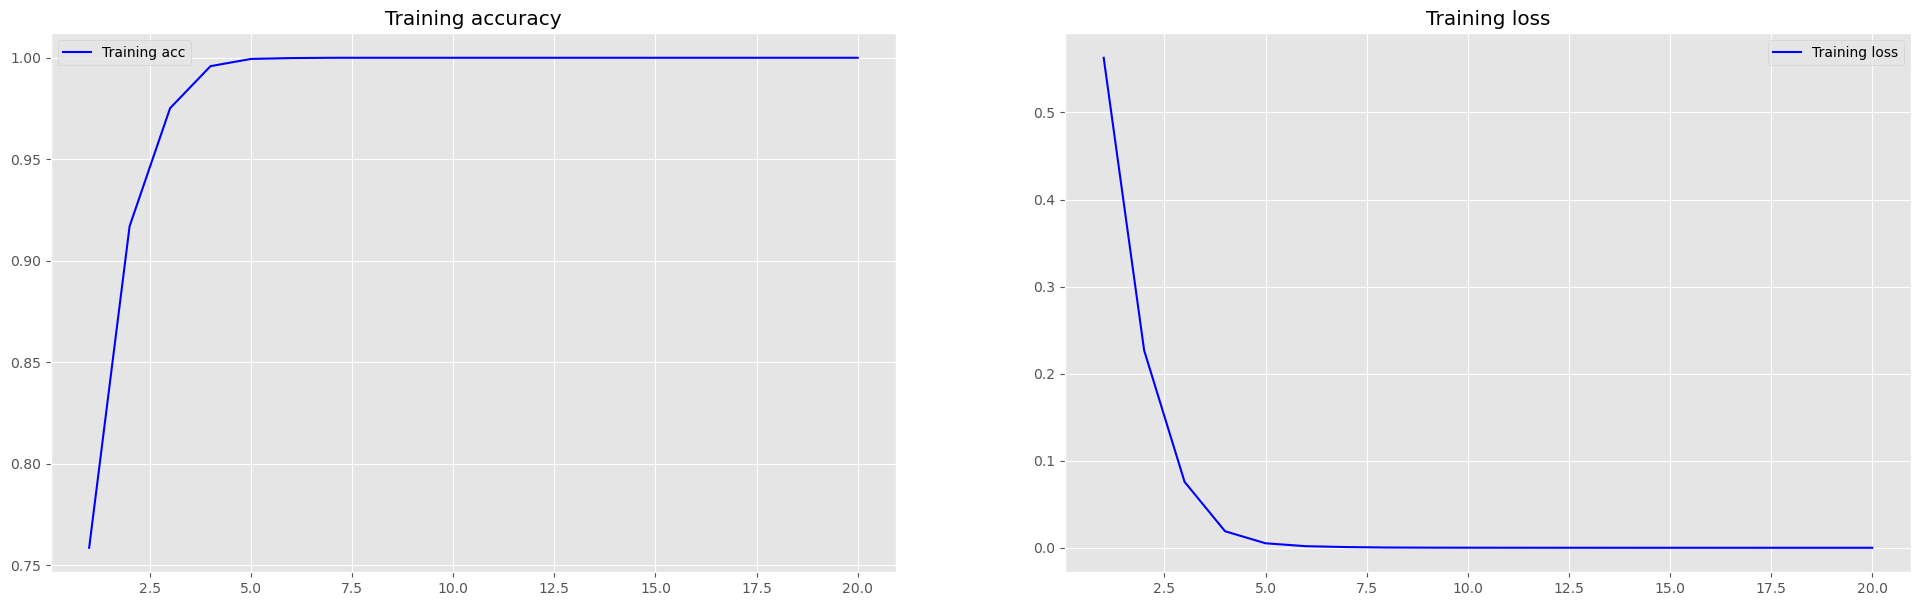

In [58]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_train(train):
    acc = train.history['accuracy']
    loss = train.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.legend()

%matplotlib inline
plot_train(train)

In [59]:
y_pred = model.predict(val_padded,batch_size=1)

1760/1760 [==============================] - 5s 3ms/step


In [60]:
y_pred = onehot.inverse_transform(y_pred).reshape(-1)

In [61]:
pred = accuracy_score(y_pred=y_pred, y_true=val_data['label'])
print('{:.0%}'.format(pred))

87%


In [62]:
print(classification_report(y_pred=y_pred, y_true=val_data['label']))

              precision    recall  f1-score   support

    negative       0.82      0.84      0.83       563
     neutral       0.82      0.67      0.74       187
    positive       0.90      0.92      0.91      1010

    accuracy                           0.87      1760
   macro avg       0.85      0.81      0.83      1760
weighted avg       0.87      0.87      0.87      1760



In [64]:
pickle.dump(model, open('../Model/model_CNN.h5','wb'))
pickle.dump(input_len, open('../Pickle/input_len.pkl','wb'))
pickle.dump(tokenizer, open('../Pickle/tokenizer.pkl','wb'))
pickle.dump(onehot, open('../Pickle/onehot.pkl','wb'))

In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 59, 64)            906560    
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 128)           41088     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 951875 (3.63 MB)
Trainable params: 951875 (3.63 MB)
Non-trainable params: 0 (0.00 Byte)
__________________